# Experimenting with GraphXAI on MUTAG

In this Notebook, we train a simple GNN (namely, GCN) on the MUTAG dataset, and build a simple pipeline to use the trained model to make predictions on masked graphs.

Other useful (?) things in PyG:
- torch_geometric.utils.k_hop_subgraph
- torch_geometric.utils.index_to_mask

TODO:
- Improve Accuracy performance
- Try out different Architectures (at least GIN, GAT, GraphConv)

In [25]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import graphxai
from graphxai.datasets.real_world.MUTAG import MUTAG
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
dataset = MUTAG(root='../Datasets/GraphXAI/', seed=1234, split_sizes=(0.8, 0.1, 0.1))
dataset.graphs.data.to(device)
num_nodes_features = dataset.graphs.num_node_features
num_classes = dataset.graphs.num_classes

train_loader = DataLoader(dataset[dataset.train_index], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset[dataset.val_index], batch_size=len(dataset.val_index), shuffle=False)
test_loader = DataLoader(dataset[dataset.test_index], batch_size=len(dataset.test_index), shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\ProgramData\mambaforge\envs\PyTorch2\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## GCN

In [2]:
from graphxai.gnn_models.graph_classification import GCN_3layer

# Model and optimizer
model = GCN_3layer(num_nodes_features, 64, num_classes).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
save_path = Path(f'graphxai/gnn_models/ckpt/{model.__class__.__name__}_best.pth')

GCN_3layer(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [14]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [15]:
# Skip to avoid training
best_val_acc = 0
for epoch in range(1, 200):
#    train() # uncomment to train
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Save best model on validation set
    if epoch == 1 or val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f'Best model saved at epoch {epoch}')

Epoch: 001, Train Acc: 0.6600, Val Acc: 0.6316, Test Acc: 0.7368
Best model saved at epoch 1
Epoch: 002, Train Acc: 0.6600, Val Acc: 0.6316, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6600, Val Acc: 0.6316, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6600, Val Acc: 0.6316, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6600, Val Acc: 0.6316, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.7333, Val Acc: 0.5789, Test Acc: 0.7895
Epoch: 007, Train Acc: 0.7533, Val Acc: 0.6316, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.7267, Val Acc: 0.6316, Test Acc: 0.7895
Epoch: 009, Train Acc: 0.7267, Val Acc: 0.5263, Test Acc: 0.7895
Epoch: 010, Train Acc: 0.7400, Val Acc: 0.5789, Test Acc: 0.7368
Epoch: 011, Train Acc: 0.7333, Val Acc: 0.5263, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7600, Val Acc: 0.6316, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7333, Val Acc: 0.5789, Test Acc: 0.8421
Epoch: 014, Train Acc: 0.7533, Val Acc: 0.5789, Test Acc: 0.7368
Epoch: 015, Train Acc: 0.7467, Val Acc: 0.5789, Test Acc: 0.78

In [ ]:
# Load best model
model.load_state_dict(torch.load(save_path))

# Get the accurate samples on the test set (we explain only true positives for now)
correct_samples = []
for data in test_loader:  # Only one loop (#num_batches = 1)
    out = model(data.x, data.edge_index, data.batch)  
    pred = out.argmax(dim=1)
    correct_samples = data[pred == data.y]

In [20]:
# Samples have +- 20 nodes, and both 0 and 1 are predicted
for i, data in enumerate(correct_samples):
    print(f"{i}) {data.num_nodes}, {data.y.item()}")

0) 22, 1
1) 15, 1
2) 12, 0
3) 14, 0
4) 12, 0
5) 20, 1
6) 20, 1
7) 20, 1
8) 14, 0
9) 26, 1
10) 24, 1
11) 22, 1
12) 22, 1
13) 19, 1
14) 23, 1
15) 22, 1


In [4]:
from torch_geometric.utils import index_to_mask, to_dense_adj

def mask_nodes(input, nodes_to_remove):
    """
    Mask nodes in a graph.
    :param input: torch.Data containing 1 graph.
    :param nodes_to_remove: list of node indexes to remove.
    :return: A subgraph of the original.
    """
    data = input.clone()
    mask = torch.ones(data.num_nodes, dtype=torch.bool)
    mask[nodes_to_remove] = False
    masked_input = data.subgraph(mask)
    masked_input.validate()
    
    return masked_input

In [22]:
# Let us try it out on one sample
sample = correct_samples[2].clone().to('cpu')
print(sample)

mask = [1,5,10,11]

masked_sample = mask_nodes(sample, nodes_to_remove=mask)
print(masked_sample)

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])
Data(edge_index=[2, 10], x=[8, 7], edge_attr=[10, 4], y=[1])


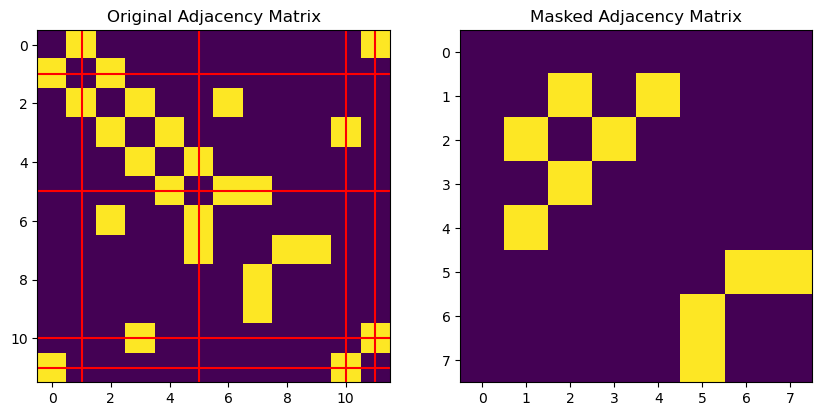

In [23]:
# Plot the original and masked graph Adjacency matrix
adj = to_dense_adj(sample.edge_index)[0]
masked_adj = to_dense_adj(masked_sample.edge_index)[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(adj, cmap='viridis')
ax[0].set_title('Original Adjacency Matrix')
for n in mask:
    ax[0].axvline(n, color='r')
    ax[0].axhline(n, color='r')

ax[1].imshow(masked_adj, cmap='viridis')
ax[1].set_title('Masked Adjacency Matrix')
plt.show()

In [24]:
# Make predictions on the masked graph
masked_loader = DataLoader([masked_sample.to(device)], batch_size=1, shuffle=False) # model forward pass needs a DataLoader
model.eval()
for data in masked_loader:
    out = model(data.x, data.edge_index, data.batch)  
    pred = out.argmax(dim=1)
    print(f'Prediction: {pred.item()}')
    print(f'Ground truth: {data.y.item()}')

Prediction: 0
Ground truth: 0
